# PySAM DOE Data Prize Webinar

## Modeling capabilities of PySAM and pvlib with use cases for DOE Data Prize datasets

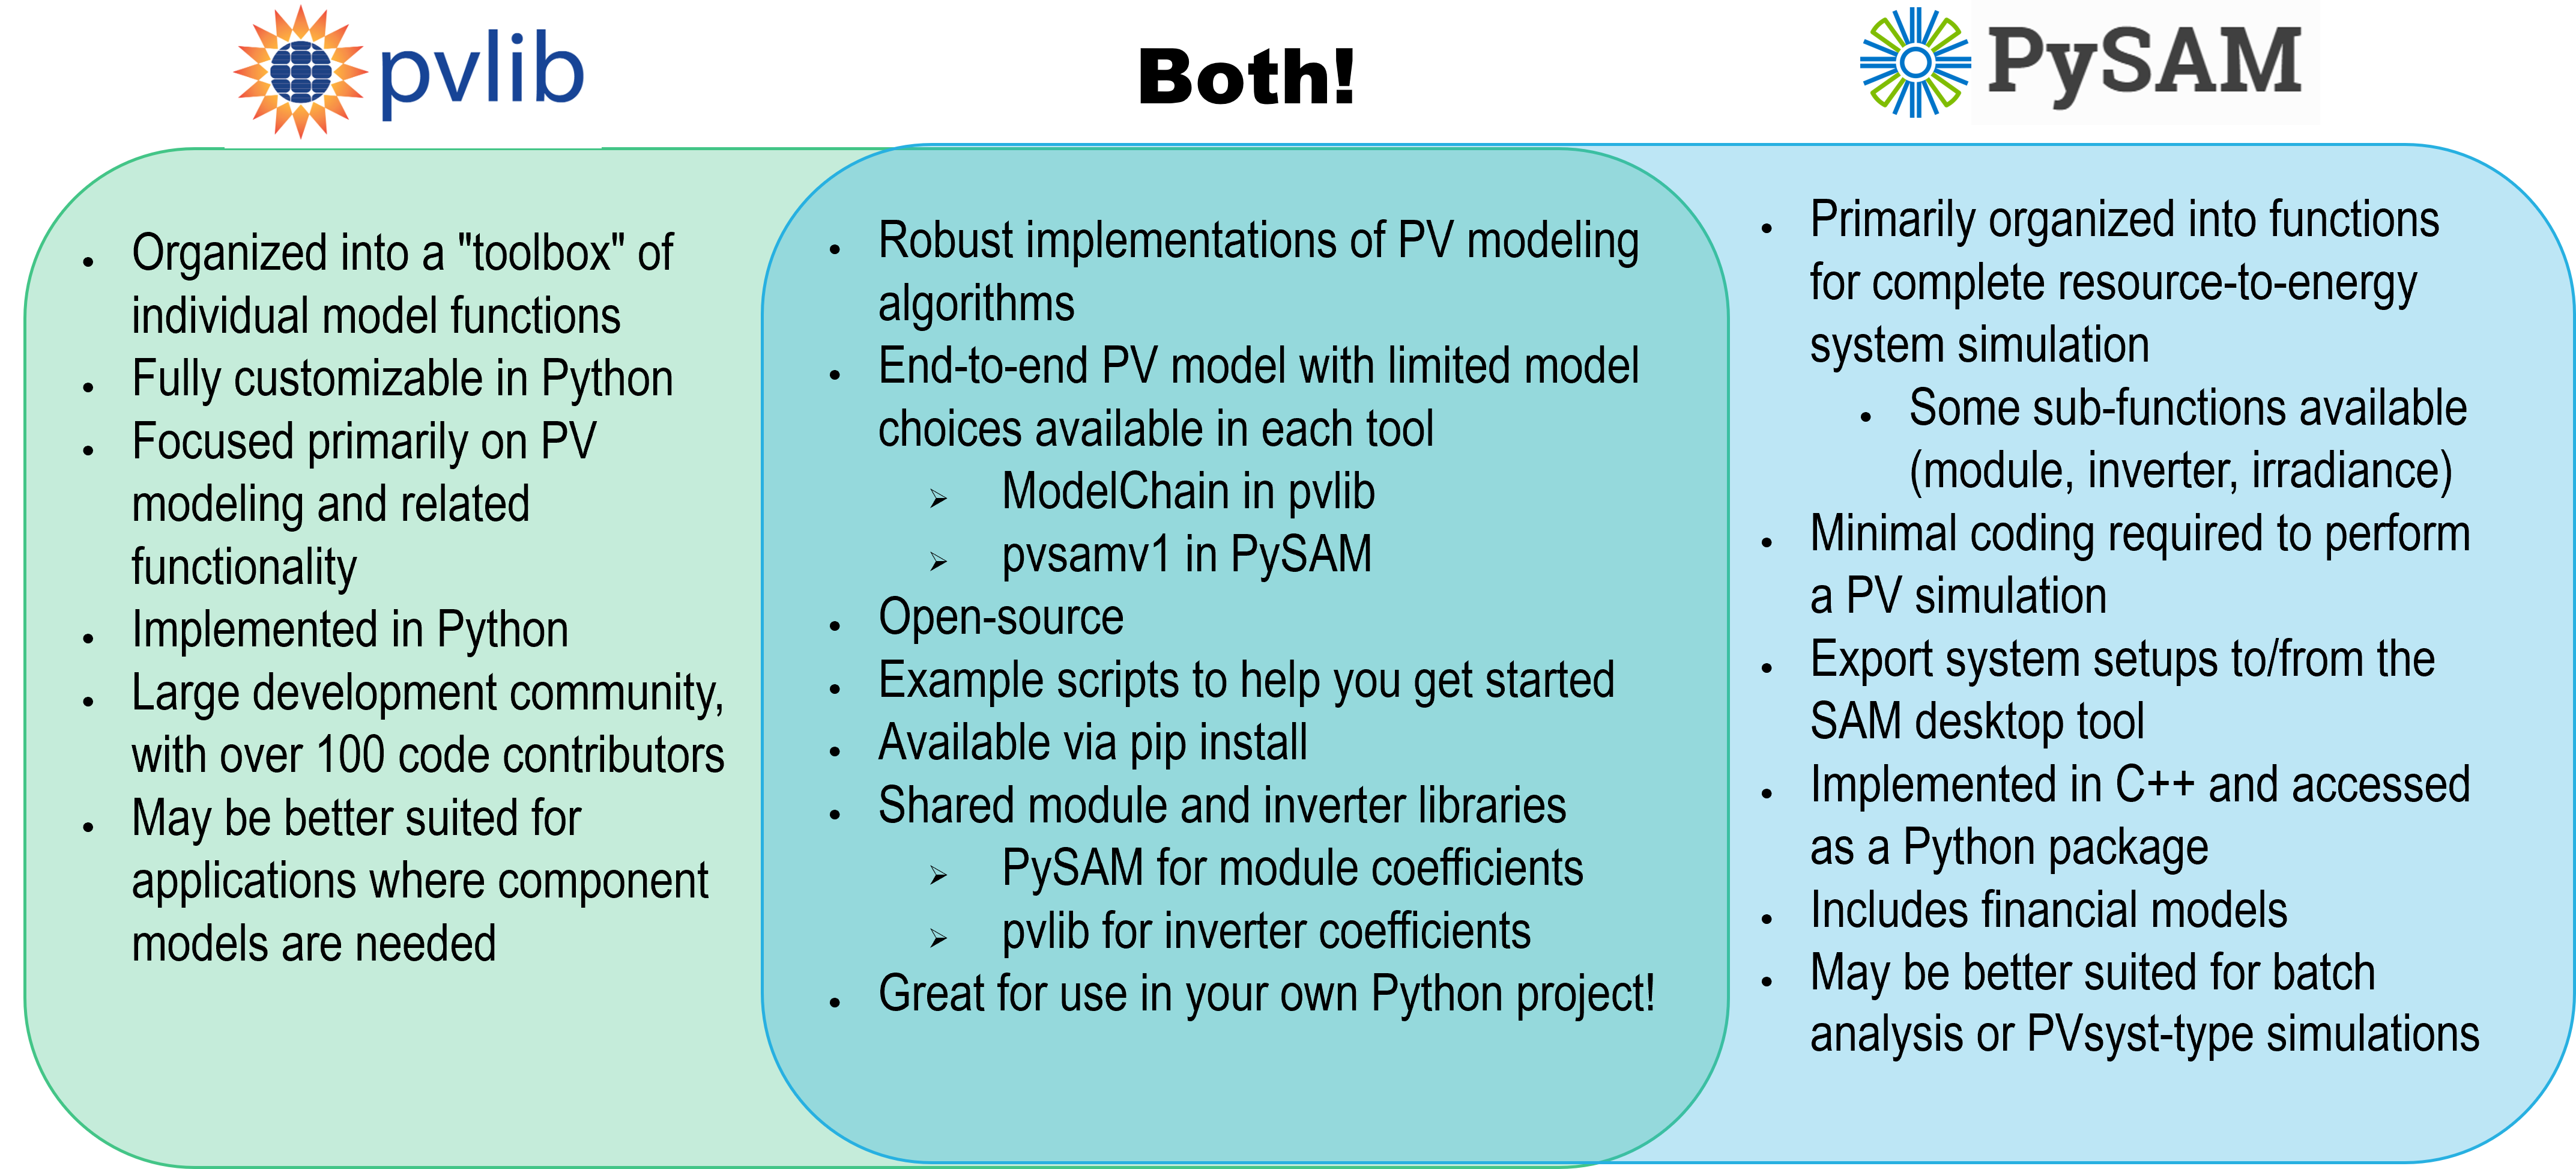

## Setting up PySAM case

### 1. Import PySAM modules
### 2. Load in weather data
### 3. Set up PV system design
### 4. Run model timestep-by-timestep
### 5. Compare results to measured plant data
### 6. Extra model features for monitoring, etc. 


In [1]:
#Setting up PySAM
#bring in PV module
import PySAM as pysam
import PySAM.Pvsamv1 as pv
#bring in LCOE calculator for example
import PySAM.Lcoefcr as lcoe
import matplotlib.pyplot as plt
import pandas as pd #Data processing
import json
import datetime
import PySAM.ResourceTools

## Weather Data

### Option 1. Read from file
-Use SAM weather file formats such as that downloaded from NSRDB
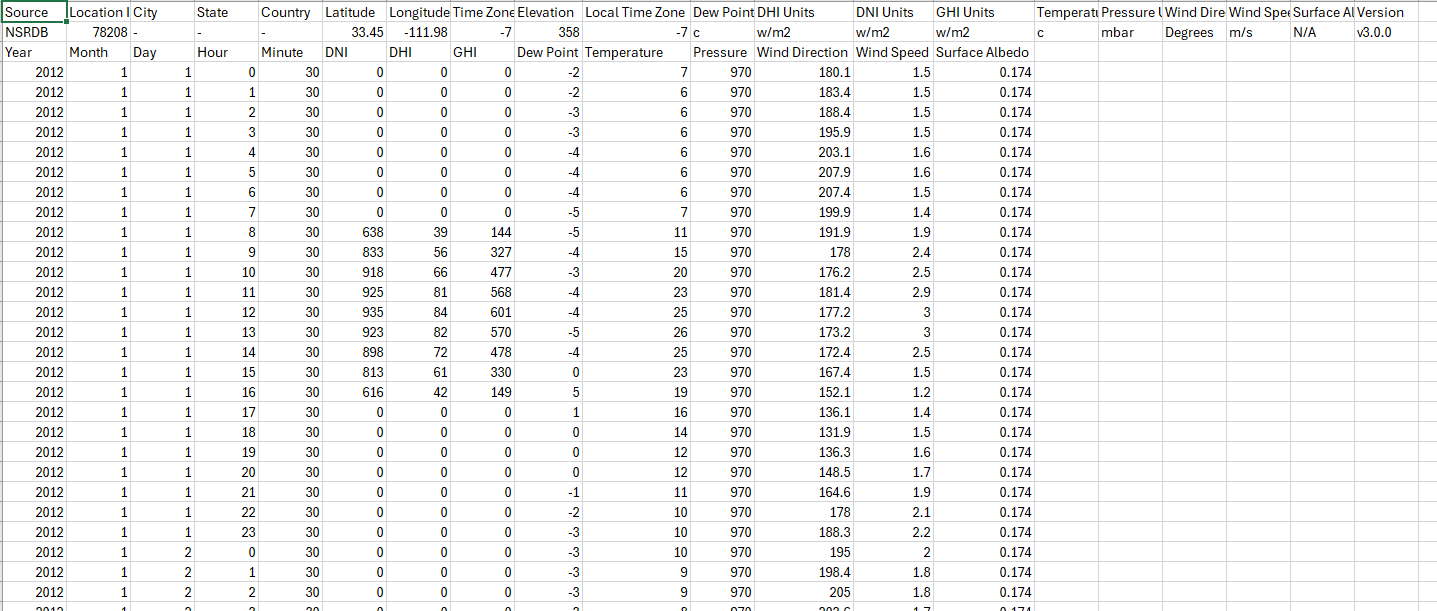

### Option 2: Read from dictionary
-solar_resource_data dictionary can store values for 'dhi', 'ghi', 'dni', 'poa', 'tamb', etc. for full year, partial year, or single time step simulations
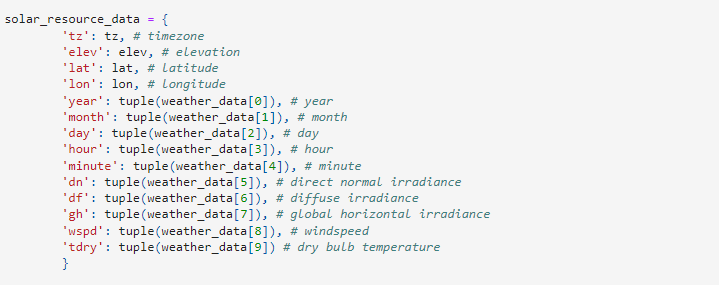

### DOE Data Prize Datasets
- System 9068 (SR_CO) system
- Single-axis tracking system
  
  

In [2]:
#Weather data
#Additional data access tools available at https://github.com/NREL/pvdaq_access
weather_data_prize = pd.read_csv('9068_irradiance_data.csv')
amb_weather_data = pd.read_csv('9068_environment_data.csv')
weather_data_prize["measured_on"] = pd.DatetimeIndex(pd.to_datetime(weather_data_prize["measured_on"], utc=False))
weather_data_prize = weather_data_prize.set_index("measured_on")
weather_data_prize.head()

amb_weather_data["measured_on"] = pd.DatetimeIndex(pd.to_datetime(amb_weather_data["measured_on"], utc=False))
amb_weather_data = amb_weather_data.set_index("measured_on")
amb_weather_data.head()

,weather_station_ambient_temperature_(c)_o_149727,thermocouple_pad_1_back-of-module_temperature_1_(c)_o_149728,thermocouple_pad_1_back-of-module_temperature_2_(c)_o_149729,thermocouple_pad_2_back-of-module_temperature_1_(c)_o_149730,thermocouple_pad_2_back-of-module_temperature_2_(c)_o_149731,wind_sensor_max_wind_speed_(m/s)_o_149732,wind_sensor_wind_direction_o_149733,wind_sensor_wind_direction_fast_o_149735,wind_sensor_wind_speed_(m/s)_o_149736,wind_sensor_wind_speed_fast_(m/s)_o_149737,...,inverter_module_2.4_temperature_t2_(c)_inv_149817,inverter_module_2.4_temperature_t3_(c)_inv_149818,inverter_1_max_igbt_temperature_(c)_inv_149819,inverter_1_min_igbt_temperature_(c)_inv_149820,inverter_1_derating_ambient_temperature_(c)_inv_149821,inverter_1_temperature_int_(c)_inv_149822,inverter_2__max_igbt_temperature_(c)_inv_149823,inverter_2_min_igbt_temperature_(c)_inv_149824,inverter_2_derating_ambient_temperature_(c)_inv_149825,inverter_2_temperature_int_(c)_inv_149826
measured_on,,,,,,,,,,,,,,,,,,,,,
2017-08-23 17:45:00,0.0,39.20,39.20,38.6,39.8,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-23 17:50:00,0.0,37.95,37.95,37.3,38.6,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-23 17:55:00,0.0,36.60,36.60,35.9,37.3,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-23 18:00:00,0.0,35.50,35.50,34.8,36.2,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-23 18:05:00,0.0,34.65,34.65,34.1,35.2,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Weather data for 2019
weather_data_prize_2019 = weather_data_prize.loc['2019']
amb_weather_data_2019 = amb_weather_data.loc['2019']

weather_data_prize_2019.to_csv('2019_weather_data.csv')
amb_weather_data_2019.to_csv('2019_amb_data.csv')

## PV System Design
### Option 1 (recommended): set up PV system design in SAM GUI
- Set module, inverter specs
- Set modules per string, number of parallel strings
- Define tilt (or tracking), azimuth, GCR
- Specify system losses
- Once system design is set, 'Generate Code' to PySAM json
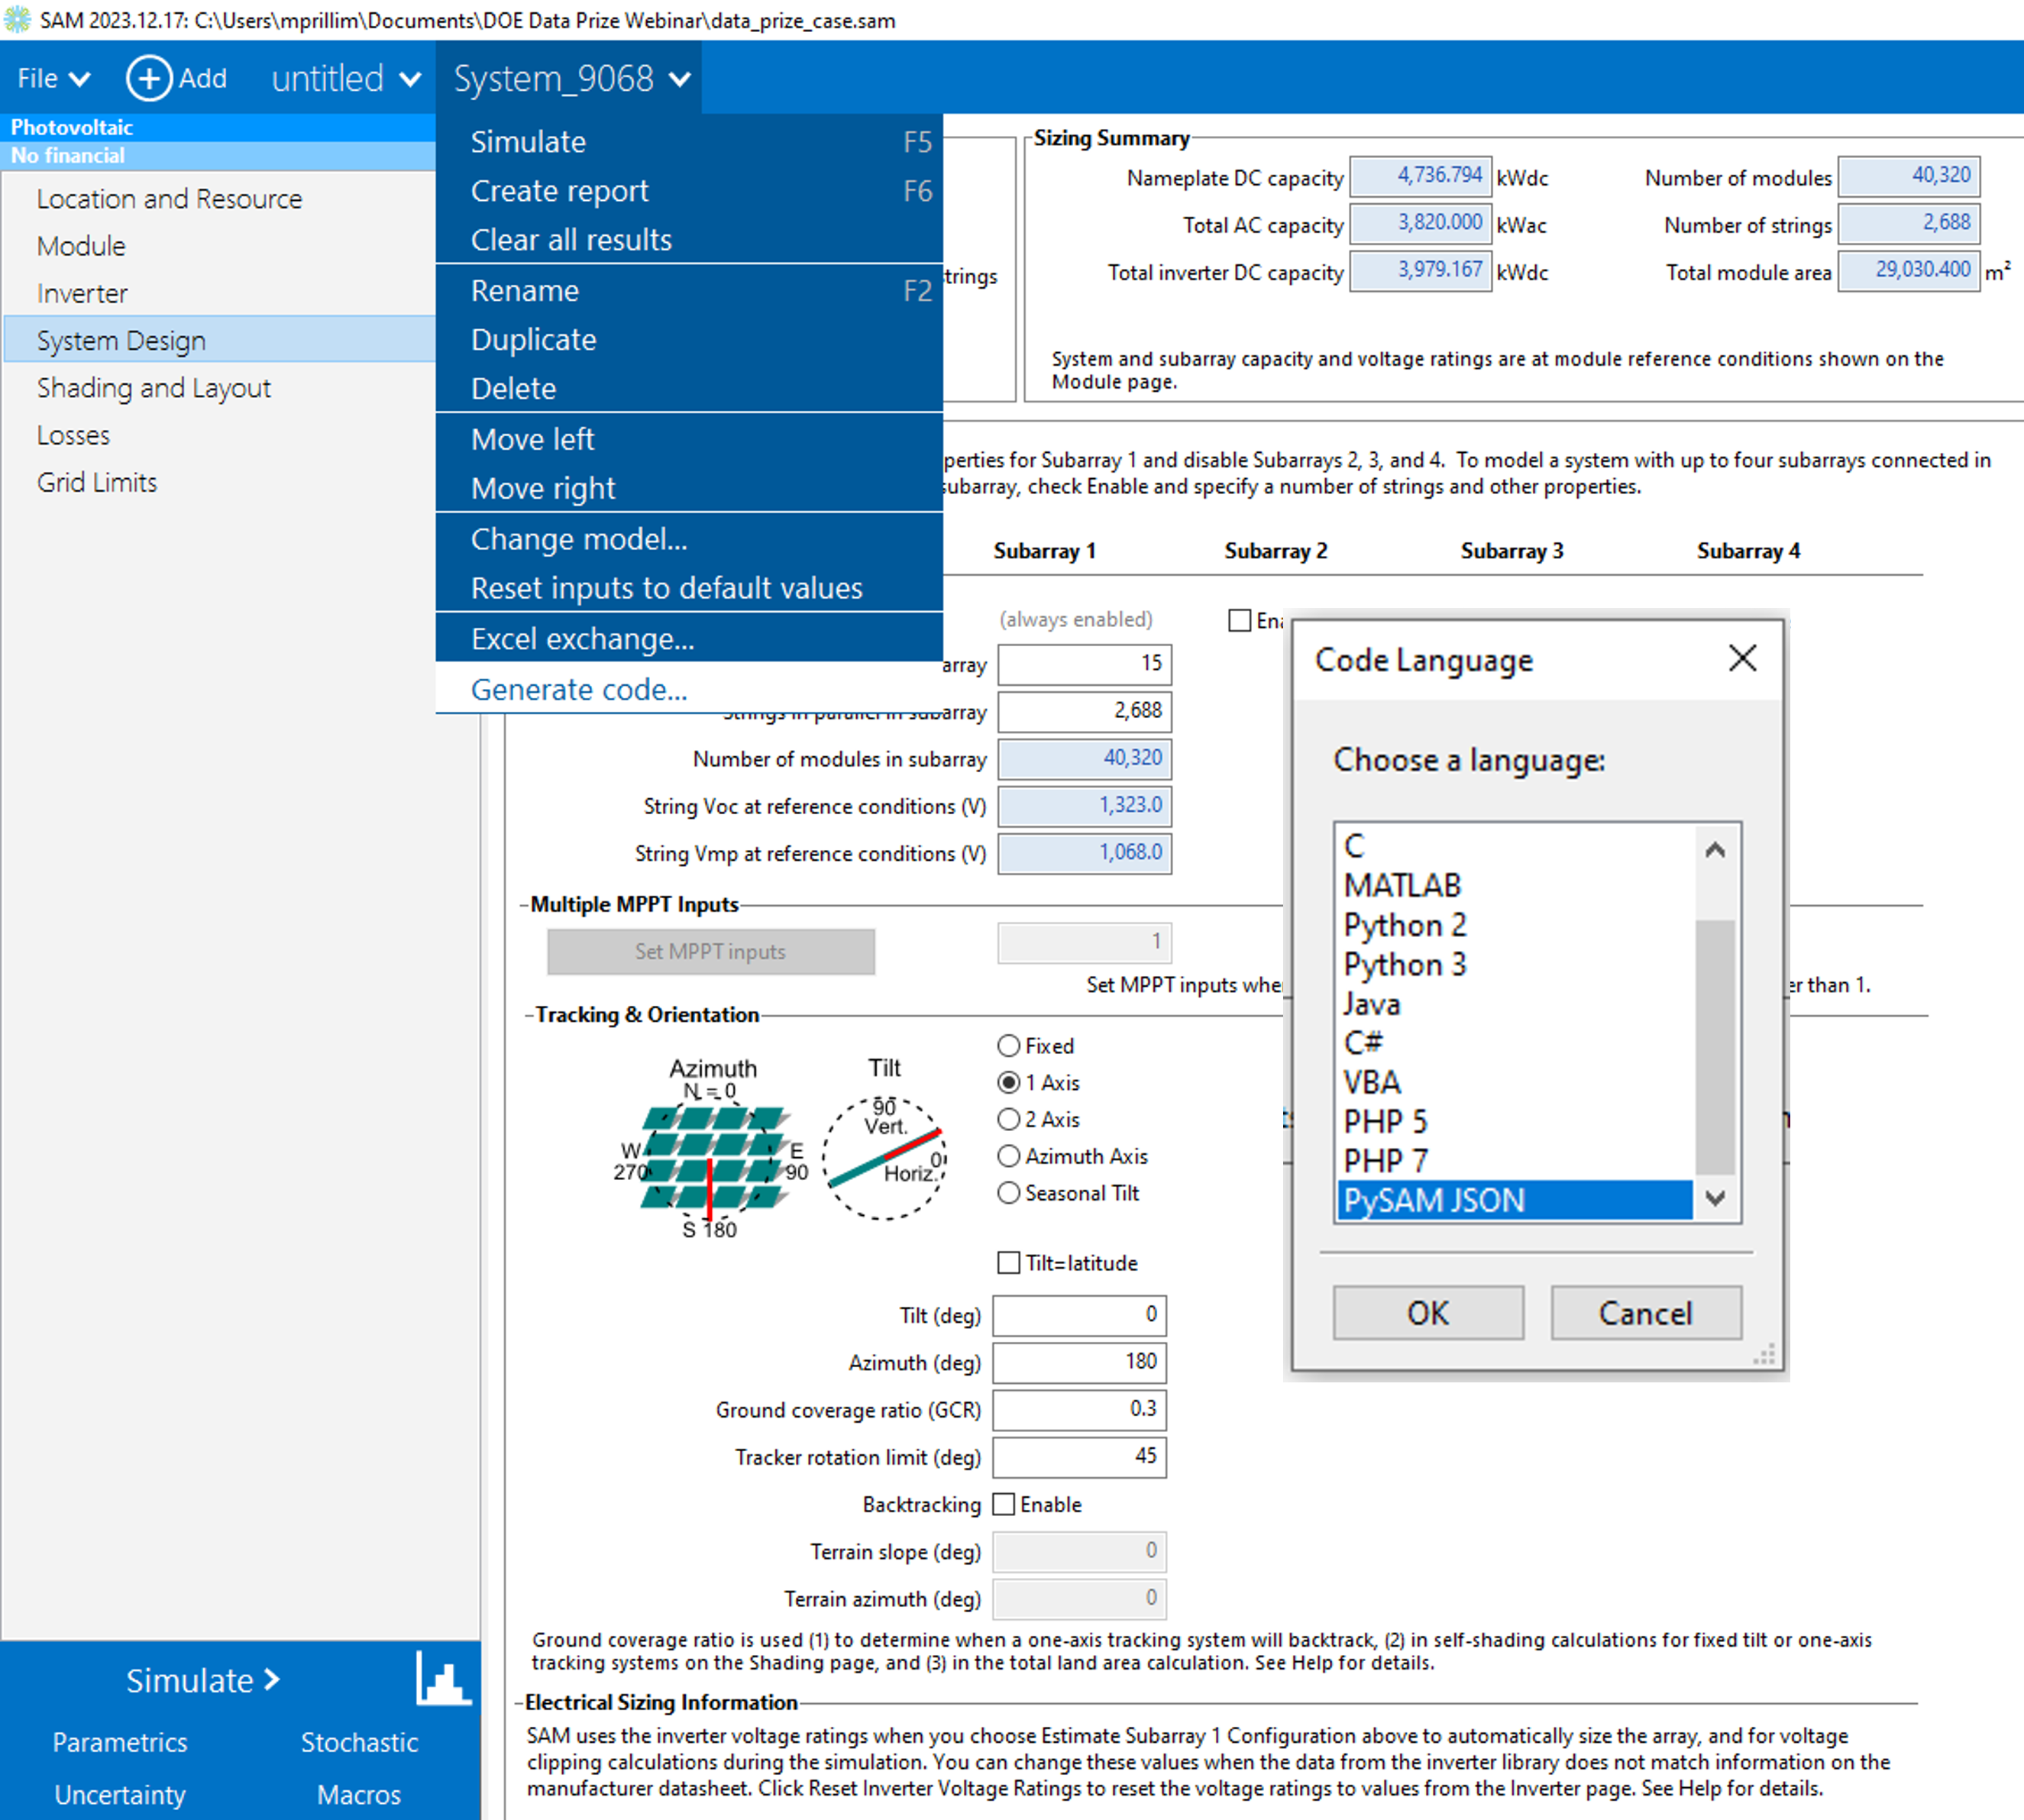

In [4]:
# create a new instance of the Pvsamv1 module
pv_model = pv.new()
# get the inputs from the JSON file from GUI
with open( 'System_9068_pvsamv1.json', 'r') as f:
        pv_inputs = json.load( f )

# iterate through the input key-value pairs and set the module inputs
for k, v in pv_inputs.items():
    if k != 'number_inputs':
        pv_model.value(k, v)

In [5]:
solar_resource_data = {
        'tz': -7, # timezone
        'elev': 1407.0, # elevation
        'lat': 40.3864, # latitude
        'lon': -104.5512, # longitude
        'year': tuple(weather_data_prize_2019.index.year), # year
        'month': tuple(weather_data_prize_2019.index.month), # month
        'day': tuple(weather_data_prize_2019.index.day), # day
        'hour': tuple(weather_data_prize_2019.index.hour), # hour
        'minute': tuple(weather_data_prize_2019.index.minute), # minute
        'poa': tuple(weather_data_prize_2019['pyranometer_(class_a)_pad_2_poa_irradiance_(w/m2)_o_149725']),
        'wspd': tuple(amb_weather_data_2019['wind_sensor_max_wind_speed_(m/s)_o_149732']), # windspeed
        'tdry': tuple(amb_weather_data_2019['weather_station_ambient_temperature_(c)_o_149727']) # dry bulb temperature
        }
#pv_model.SolarResource.assign({'solar_resource_data': solar_resource_data})
#Assign weather data from NSRDB
pv_model.SolarResource.assign({'solar_resource_file': '40.3864_-104.5512_psm3-5min_5_2021.csv'})

### Run model
- pv_model.execute() to run SAM module
  
- Outputs in pv_model.Outputs, can export to dictionary with .export()

- Time series, annual summation metrics

- "gen": time series kW output

9580759.524304047  kWh


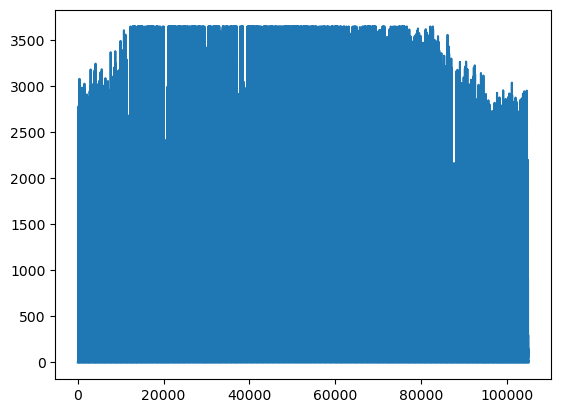

In [6]:
pv_model.execute(0)
out = pv_model.Outputs.export()
predictions = pd.DataFrame({"AC": out["gen"]})
predictions["AC"].plot()
print(pv_model.Outputs.annual_energy, " kWh")

## Compare to Measured Data
-Use measured data to compare against simulated results

-Can compare timestep to timestep (non-annual), or for entire year


In [7]:
measured_data = pd.read_csv("9068_ac_power_data.csv")
measured_data["measured_on"] = pd.DatetimeIndex(pd.to_datetime(measured_data["measured_on"], utc=False))
measured_data = measured_data.set_index("measured_on")
measured_data_ex = measured_data.loc["2022"]
predictions = predictions.set_index(measured_data_ex.index.copy())
measured_data_ex
measured_ac_kw = measured_data_ex["inverter_1_ac_power_(kw)_inv_150143"] + measured_data_ex["inverter_2_ac_power_(kw)_inv_150144"]

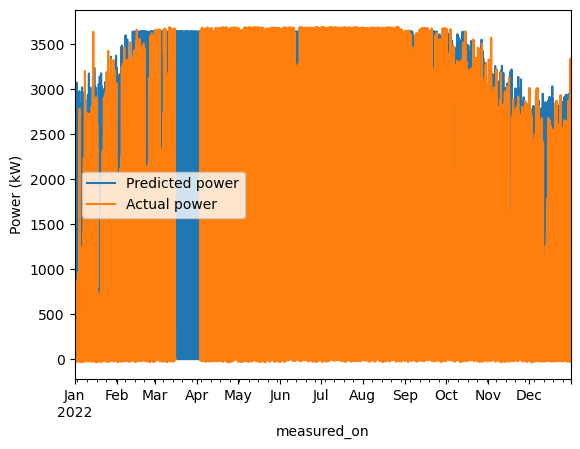

In [8]:
predictions['AC'].plot()
measured_ac_kw.plot()
plt.legend(["Predicted power", "Actual power"])
plt.ylabel("Power (kW)")
measured_ac_kwh = measured_ac_kw * 5.0 / 60.0 #5-minute data

## Financial Model 
- SAM has detailed financial models with discounted cash flows
- Front of meter, behind the meter perspectives
- Also able to run simple LCOE calculator

In [9]:
lcoe_model = lcoe.new()
lcoe_model.SimpleLCOE.annual_energy = pv_model.Outputs.annual_energy
lcoe_model.SimpleLCOE.capital_cost = 10000000 #capex in $, not based on actual cost data
lcoe_model.SimpleLCOE.fixed_charge_rate = 0.1 #Can be calculated
lcoe_model.SimpleLCOE.fixed_operating_cost = 50000 #annual opex in $, not based on actual cost data
lcoe_model.SimpleLCOE.variable_operating_cost = 0.1 #variable operating cost in $/kWh, not based on actual cost data
lcoe_model.execute()
print("Levelized Cost of Energy:",lcoe_model.Outputs.lcoe_fcr, " $/kWh")

Levelized Cost of Energy: 0.2095946513777333  $/kWh


## Non-annual Simulations
- Run subset of year or single time step
- Monitor measured vs modeled based on incoming data streams
- Focused analysis on segments of year, individual days
- Faster parametric sweeps, iteration over input options and ranges
- Use solar_resource_data instead of solar_resource_file


In [10]:
pv_model = pv.new()
#Model single inverter instead of both inverters
with open( 'System_9068_Inv_pvsamv1.json', 'r') as f:
        pv_inputs = json.load( f )

# iterate through the input key-value pairs and set the module inputs
for k, v in pv_inputs.items():
    if k != 'number_inputs':
        pv_model.value(k, v)


In [11]:
#Unassign Weather file to use dictionary of weather values instead
pv_model.unassign("solar_resource_file")
#Unassign other annual values
pv_model.unassign("subarray1_shading_timestep")

#Pull weather data from site for specific day with trackers not moving all day (9/16/23)
weather_data_prize_example = weather_data_prize.loc[datetime.date(2023, 9, 16):datetime.date(2023,9,17)]
amb_weather_data_example = amb_weather_data.loc[datetime.date(2023, 9, 16):datetime.date(2023,9,17)]
#weather_data_prize_example = weather_data_prize["2023-9-16"]

#Assign solar_resource_data with poa and solar data from site data
solar_resource_data = {
        'tz': -7, # timezone
        'elev': 1407.0, # elevation
        'lat': 40.3864, # latitude
        'lon': -104.5512, # longitude
        'year': tuple(weather_data_prize_example.index.year), # year
        'month': tuple(weather_data_prize_example.index.month), # month
        'day': tuple(weather_data_prize_example.index.day), # day
        'hour': tuple(weather_data_prize_example.index.hour), # hour
        'minute': tuple(weather_data_prize_example.index.minute), # minute
        'poa': tuple(weather_data_prize_example['pyranometer_(class_a)_pad_2_poa_irradiance_temp_compensated_(w/m2)_o_149726']),
        'wspd': tuple(amb_weather_data_example['wind_sensor_max_wind_speed_(m/s)_o_149732']), # windspeed
        'tdry': tuple(amb_weather_data_example['weather_station_ambient_temperature_(c)_o_149727']) # dry bulb temperature
}

#Assign solar_resource_data to model, set irradiance calculation mode to POA from pyranometer (determined from site metadata)
pv_model.SolarResource.assign({"solar_resource_data": solar_resource_data})
pv_model.SolarResource.assign({"irrad_mode":4}) #4 - POA irradiance from pyranometer

In [12]:
#Run 1 day analysis
pv_model.execute(1)

#Load tracker data
tracker_data = pd.read_csv("9068_tracker_data.csv")
tracker_data["measured_on"] = pd.DatetimeIndex(pd.to_datetime(tracker_data["measured_on"], utc=False))
tracker_data = tracker_data.set_index("measured_on")


### Custom Tracker Rotation Angles
- User-defined tracker rotation angles rather than default SAM sun-following algorithm
- SAM covers sun-following tracker algorithm with backtracking, slope-aware backtracking (single fixed slope)
- Useful for analyzing misaligned tracker, stuck trackers, custom tracker algorithms
- Currently SDK only, looking at desktop tool integration in future

Text(0, 0.5, 'Power (kW)')

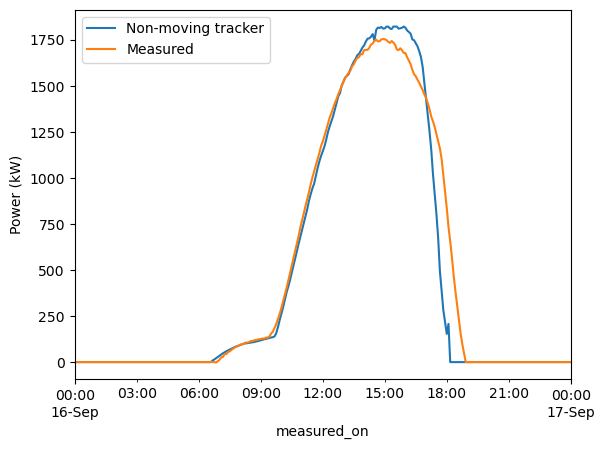

In [13]:
#Pull tracker rotation angles from site data
stuck_tracker_data = tracker_data.loc[datetime.date(2023, 9, 16):datetime.date(2023,9,17), "tracker_1.1-101_tracker_angle_trkr_149827"]

#Turn off custom_rotation_angles
pv_model.SystemDesign.subarray1_use_custom_rot_angles = 0
pv_model.execute(1)
out = pv_model.Outputs.export()
tracker_predictions = pd.DataFrame({"sun_angles": out['subarray1_axisrot']})

#Turn on custom rotation angles, set array to tracker angles from array
pv_model.SystemDesign.subarray1_use_custom_rot_angles = 1
pv_model.SystemDesign.subarray1_custom_rot_angles_array = stuck_tracker_data
pv_model.execute(1)
out = pv_model.Outputs.export()
tracker_predictions["Stuck_tracking"] = out["gen"]
tracker_predictions["custom_angles"] = out["subarray1_axisrot"]
tracker_predictions["calculated_temps"] = out["subarray1_celltemp"]

#Look at results
measured_data_stuck = measured_data.loc[datetime.date(2023, 9, 16):datetime.date(2023,9,17)]
measured_data_kW = measured_data_stuck["inverter_1_ac_power_(kw)_inv_150143"] #+ measured_data_stuck["inverter_2_ac_power_(kw)_inv_150144"]
#measured_data_kW = measured_data_stuck["inverter_2_ac_power_(kw)_inv_150144"]
tracker_predictions = tracker_predictions.set_index(measured_data_stuck.index.copy())
tracker_predictions["Stuck_tracking"].plot()
measured_data_kW.plot()
plt.legend(["Non-moving tracker", "Measured"])
plt.ylabel("Power (kW)")

Text(0, 0.5, 'Tracker rotation angle (degrees)')

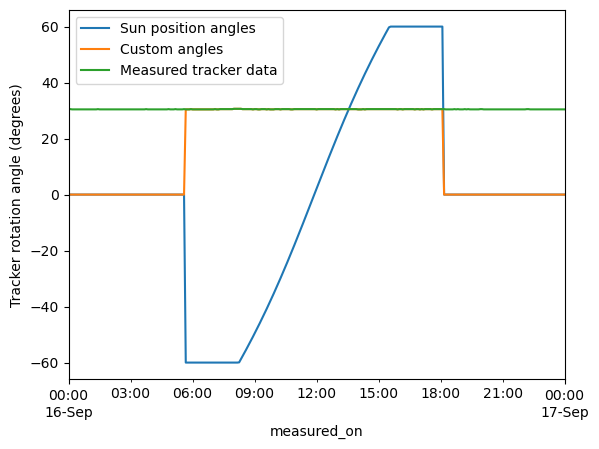

In [14]:
tracker_predictions["sun_angles"].plot()
tracker_predictions["custom_angles"].plot()
stuck_tracker_data.plot()
plt.legend(["Sun position angles", "Custom angles", "Measured tracker data"])
plt.ylabel("Tracker rotation angle (degrees)")

### Custom module temperatures
- Replace cell temperature in calculation with user-defined cell temperatures
- Useful for using cell temperature models not in SAM, using measured temperatures
- Currently SDK only, evaluating for future integration into desktop tool

Text(0, 0.5, 'Degrees Celsius')

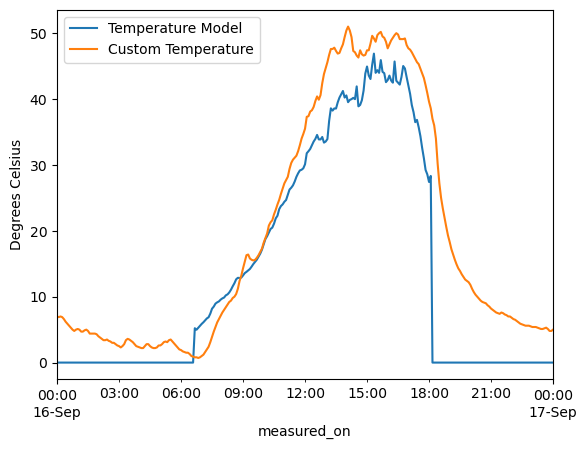

In [15]:
pv_model.SystemDesign.subarray1_use_custom_cell_temp = 1 #Turn on custom cell temperatures
pv_model.SystemDesign.subarray1_custom_cell_temp_array = amb_weather_data_example["thermocouple_pad_1_back-of-module_temperature_1_(c)_o_149728"]
pv_model.execute()
out = pv_model.Outputs.export()
tracker_predictions["custom_temps"] = out["subarray1_celltemp"]
tracker_predictions["calculated_temps"].plot()
tracker_predictions["custom_temps"].plot()
plt.legend(["Temperature Model", "Custom Temperature"])
plt.ylabel("Degrees Celsius")